In [133]:
%reload_ext autoreload
%autoreload 2

In [134]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [135]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [136]:
from src.loader import SlackDataLoader


In [137]:
from src.utils import (
    convert_2_timestamp,
    get_tagged_users,
    map_userid_2_realname,
    get_msgs_df_info,
    break_combined_weeks,
    get_messages_dict,
    from_msg_get_replies,
    msgs_to_df,process_msgs,
    get_messages_from_channel,
)

In [138]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [139]:
path = r"C:\Users\CIAD\Music\week0_starter_network_analysis\anonymized"# Assuming you want to parse the first channel in the list
loader = SlackDataLoader(path)
loader

In [140]:
dfall = loader.slack_parser(path )
print(dfall.head())

  msg_type                                        msg_content  \
0  message  Hi guys,\nI thought having a group chat would ...   
1  message                                             good!!   
2  message                              Thanks <@U03U9FWPNCE>   
3  message                                Nice <@U03U9FWPNCE>   
4  message  I have been missing deadlines and I am trying ...   

        sender_name      msg_sent_time msg_dist_type time_thread_start  \
0   Anita Rodriguez  1661766066.863109          text                 0   
1  Michael Gonzalez  1661766159.852649          text                 0   
2     Robert Carter  1661766226.215889          text                 0   
3    Phillip Atkins  1661766241.597379          text                 0   
4   Anita Rodriguez  1661766295.939119          text                 0   

   reply_count  reply_users_count reply_users tm_thread_end  \
0            0                  0           0             0   
1            0                  0     

In [141]:
print(dfall.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17748 entries, 0 to 17747
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   msg_type           17748 non-null  object
 1   msg_content        17748 non-null  object
 2   sender_name        17748 non-null  object
 3   msg_sent_time      17748 non-null  object
 4   msg_dist_type      17748 non-null  object
 5   time_thread_start  17748 non-null  object
 6   reply_count        17748 non-null  int64 
 7   reply_users_count  17748 non-null  int64 
 8   reply_users        17748 non-null  object
 9   tm_thread_end      17748 non-null  object
 10  channel            17748 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.5+ MB
None


In [142]:
channels = loader.channels
dfal2 = loader.parse_slack_reaction(channels )
print(dfal2)

   reaction_name reaction_count reaction_users_count message user_id  \
0            NaN            NaN                  NaN     NaN     NaN   
1            NaN            NaN                  NaN     NaN     NaN   
2            NaN            NaN                  NaN     NaN     NaN   
3            NaN            NaN                  NaN     NaN     NaN   
4            NaN            NaN                  NaN     NaN     NaN   
5            NaN            NaN                  NaN     NaN     NaN   
6            NaN            NaN                  NaN     NaN     NaN   
7            NaN            NaN                  NaN     NaN     NaN   
8            NaN            NaN                  NaN     NaN     NaN   
9            NaN            NaN                  NaN     NaN     NaN   
10           NaN            NaN                  NaN     NaN     NaN   
11           NaN            NaN                  NaN     NaN     NaN   
12           NaN            NaN                  NaN     NaN    

In [146]:
timestamps = convert_2_timestamp('msg_sent_time', dfall)
timestamps 

['2022-08-29 02:41:06',
 '2022-08-29 02:42:39',
 '2022-08-29 02:43:46',
 '2022-08-29 02:44:01',
 '2022-08-29 02:44:55',
 '2022-08-29 02:46:07',
 '2022-08-29 02:47:51',
 '2022-08-29 02:50:12',
 '2022-08-29 02:52:30',
 '2022-08-29 02:52:46',
 '2022-08-29 02:56:05',
 '2022-08-29 03:02:27',
 '2022-08-29 03:09:57',
 '2022-08-29 03:10:12',
 '2022-08-29 03:12:00',
 '2022-08-29 04:09:12',
 '2022-08-29 04:36:11',
 '2022-08-29 07:01:36',
 '2022-08-29 07:02:24',
 '2022-08-29 07:03:01',
 '2022-08-29 07:03:28',
 '2022-08-29 07:04:13',
 '2022-08-29 07:04:39',
 '2022-08-29 07:05:28',
 '2022-08-29 07:06:53',
 '2022-08-29 07:07:18',
 '2022-08-29 07:07:21',
 '2022-08-29 07:07:49',
 '2022-08-29 07:10:17',
 '2022-08-29 07:10:35',
 '2022-08-29 07:11:18',
 '2022-08-29 07:13:19',
 '2022-08-29 07:14:13',
 '2022-08-29 07:16:22',
 '2022-08-29 07:29:36',
 '2022-08-29 12:04:44',
 '2022-08-29 12:05:48',
 '2022-08-29 12:06:38',
 '2022-08-29 12:08:35',
 '2022-08-29 12:09:37',
 '2022-08-29 12:10:06',
 '2022-08-29 12:

In [143]:
dfall['time_column'] = convert_2_timestamp('msg_sent_time', dfall)
dfall

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel,time_column
0,message,"Hi guys,\nI thought having a group chat would ...",Anita Rodriguez,1661766066.863109,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:41:06
1,message,good!!,Michael Gonzalez,1661766159.852649,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:42:39
2,message,Thanks <@U03U9FWPNCE>,Robert Carter,1661766226.215889,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:43:46
3,message,Nice <@U03U9FWPNCE>,Phillip Atkins,1661766241.597379,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:44:01
4,message,I have been missing deadlines and I am trying ...,Anita Rodriguez,1661766295.939119,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:44:55
...,...,...,...,...,...,...,...,...,...,...,...,...
17743,message,yohanes also,Paula Bryant,1663093203.238019,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-09-13 11:20:03
17744,message,the connection is very slow,Nancy Craig,1663093633.896039,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-09-13 11:27:13
17745,message,guys my network is not working,Paula Bryant,1663094118.932099,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-09-13 11:35:18
17746,message,Okay bro we will update you.,Nicholas Friedman,1663094488.880729,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-09-13 11:41:28


In [118]:
tagged_users = get_tagged_users(dfall)
community_participation = get_community_participation(dfall)
mapped_df = map_userid_2_realname(dfall)
# Continue using other functions for data exploration

TypeError: map_userid_2_realname() missing 1 required positional argument: 'comm_dict'

In [118]:
tagged_users = get_tagged_users(dfall)
community_participation = get_community_participation(dfall)
mapped_df = map_userid_2_realname(dfall)
# Continue using other functions for data exploration

TypeError: map_userid_2_realname() missing 1 required positional argument: 'comm_dict'

In [ ]:
from your_module import get_top_20_user, draw_avg_reply_count, draw_wordcloud

top_20_senders = get_top_20_user(converted_df)
draw_avg_reply_count(converted_df)
draw_wordcloud(converted_df['msg_content'])
# Continue using other functions for data analysis and visualization

In [108]:
retrive_information=get_msgs_df_info(dfall)
retrive_information

AttributeError: 'DataFrame' object has no attribute 'user'

In [144]:
timestamps = convert_2_timestamp('msg_sent_time', dfall)
timestamps 
dfall['time_column'] = convert_2_timestamp('msg_sent_time', dfall)
dfall

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel,time_column
0,message,"Hi guys,\nI thought having a group chat would ...",Anita Rodriguez,1661766066.863109,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:41:06
1,message,good!!,Michael Gonzalez,1661766159.852649,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:42:39
2,message,Thanks <@U03U9FWPNCE>,Robert Carter,1661766226.215889,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:43:46
3,message,Nice <@U03U9FWPNCE>,Phillip Atkins,1661766241.597379,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:44:01
4,message,I have been missing deadlines and I am trying ...,Anita Rodriguez,1661766295.939119,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:44:55
...,...,...,...,...,...,...,...,...,...,...,...,...
17743,message,yohanes also,Paula Bryant,1663093203.238019,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-09-13 11:20:03
17744,message,the connection is very slow,Nancy Craig,1663093633.896039,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-09-13 11:27:13
17745,message,guys my network is not working,Paula Bryant,1663094118.932099,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-09-13 11:35:18
17746,message,Okay bro we will update you.,Nicholas Friedman,1663094488.880729,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-09-13 11:41:28


In [84]:


dfall['time_column'] = convert_2_timestamp('msg_sent_time', dfall)
dfall

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel,time_column
0,message,"Hi guys,\nI thought having a group chat would ...",Anita Rodriguez,1661766066.863109,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:41:06
1,message,good!!,Michael Gonzalez,1661766159.852649,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:42:39
2,message,Thanks <@U03U9FWPNCE>,Robert Carter,1661766226.215889,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:43:46
3,message,Nice <@U03U9FWPNCE>,Phillip Atkins,1661766241.597379,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:44:01
4,message,I have been missing deadlines and I am trying ...,Anita Rodriguez,1661766295.939119,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-08-29 02:44:55
...,...,...,...,...,...,...,...,...,...,...,...,...
17743,message,yohanes also,Paula Bryant,1663093203.238019,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-09-13 11:20:03
17744,message,the connection is very slow,Nancy Craig,1663093633.896039,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-09-13 11:27:13
17745,message,guys my network is not working,Paula Bryant,1663094118.932099,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-09-13 11:35:18
17746,message,Okay bro we will update you.,Nicholas Friedman,1663094488.880729,text,0,0,0,0,0,C:\Users\CIAD\Music\week0_starter_network_anal...,2022-09-13 11:41:28


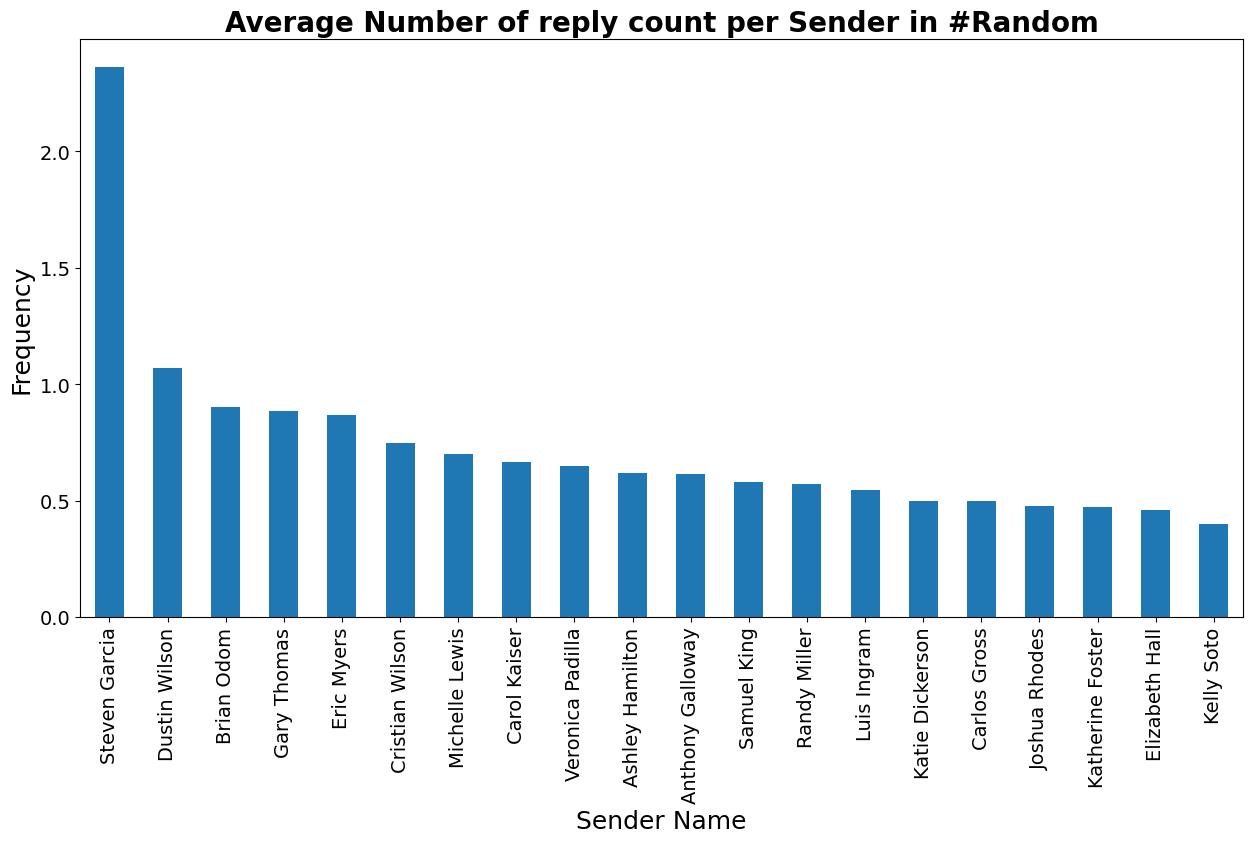

In [82]:
draw_avg_reply_count(dfall)

In [81]:
print(dfall["reply_count"].value_counts())

0     16096
1       454
2       352
3       243
4       172
5       101
6        80
7        47
9        39
8        32
10       29
11       18
12       15
13       10
15       10
16        7
14        7
17        6
18        4
24        3
27        3
21        2
19        2
22        2
23        1
20        1
33        1
31        1
25        1
63        1
57        1
75        1
44        1
30        1
45        1
61        1
54        1
36        1
Name: reply_count, dtype: int64


In [42]:
# which user has the highest number of reply counts?

In [78]:
# Find user with the highest number of reply counts
user_with_highest_reply_counts = data.groupby('sender_name')['reply_count'].sum().idxmax()
print(f"The user with the highest number of reply counts is: {user_with_highest_reply_counts}")

# Visualize reply counts per user per channel
draw_avg_reply_count(data)  # Bar chart showing average reply counts per sender
draw_avg_reply_users_count(data)  # Bar chart showing average reply user counts per sender

NameError: name 'data' is not defined

In [ ]:
# which user has the highest number of reply counts?
# Visualize reply counts per user per channel

In [ ]:
# Visualize reply counts per user per channel

In [ ]:
# what is the time range of the day that most messages are sent?


In [11]:
# what kind of messages are replied faster than others?

In [15]:
# Relationship between # of messages and # of reactions

In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [17]:
# Which users got the most reactions?

In [33]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?